# SVD with TF

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import tensorflow as tf

import matrices.loading as mload

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = (16,16)
mpl.rcParams['figure.dpi']= 200
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

In [3]:
data_path = "resources/aminer/v1" # 629814 documents
sess = tf.Session() # tensorflow

In [4]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = mload.load_matrix_jaccard_sim(data_path)

n = matrix_tmp.shape[0]

matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')

# dice
matrix_dice = tf.constant(np.divide(np.multiply(2,matrix_tmp), np.add(matrix_tmp, 1)), name='matrix_dice')

# Jaccard disimilarity
matrix_jaccard_dis =  tf.constant(np.subtract(1, matrix_tmp), name='matrix_jaccard_dis')

del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = mload.load_matrix_word2vec_sim(data_path)

matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')

del matrix_tmp

mask =  np.tri(n, k=-1) # Mask for plotting  

print(matrix_jaccard)
print(matrix_jaccard_dis)
print(matrix_dice)
print(matrix_word2vec)

Loading saved matrix ...
Loading saved matrix ...
Tensor("matrix_jaccard:0", shape=(998, 998), dtype=float32)
Tensor("matrix_jaccard_dis:0", shape=(998, 998), dtype=float32)
Tensor("matrix_dice:0", shape=(998, 998), dtype=float32)
Tensor("matrix_word2vec:0", shape=(998, 998), dtype=float32)


In [5]:
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float32), dtype=tf.float32, name='M') 
s, u, v = tf.svd(M) #SVD

# ns = n
ns = 1 # one singular value


# UDV' matrix reconstruction with ns singular values
M_ = tf.matmul(u[:,:ns], tf.matmul(tf.diag(s[:ns]), v[:,:ns], adjoint_b=True)) 
# M_ = tf.matmul(u[:,:ns], v[:,:ns], adjoint_b=True) # UV'

sess.run(tf.global_variables_initializer())  


op = M.assign(matrix_jaccard)
sess.run(op)
jaccard_approximation = sess.run(M_) # Reconstruction of the matrix M
jaccard_singular_values = sess.run(s) # Singular values  

op = M.assign(matrix_jaccard_dis)
sess.run(op)
jaccarddis_approximation = sess.run(M_)
jaccarddis_singular_values = sess.run(s)

op = M.assign(matrix_dice)
sess.run(op)
dice_approximation = sess.run(M_)
dice_singular_values = sess.run(s)

op = M.assign(matrix_word2vec)
sess.run(op)
word2vec_approximation = sess.run(M_)
word2vec_singular_values = sess.run(s)

print("SVD: Largest singular values", jaccard_singular_values[0], jaccarddis_singular_values[0], 
      dice_singular_values[0], word2vec_singular_values[0])

SVD: Largest singular values 9.587548 990.75214 16.390749 101.5215


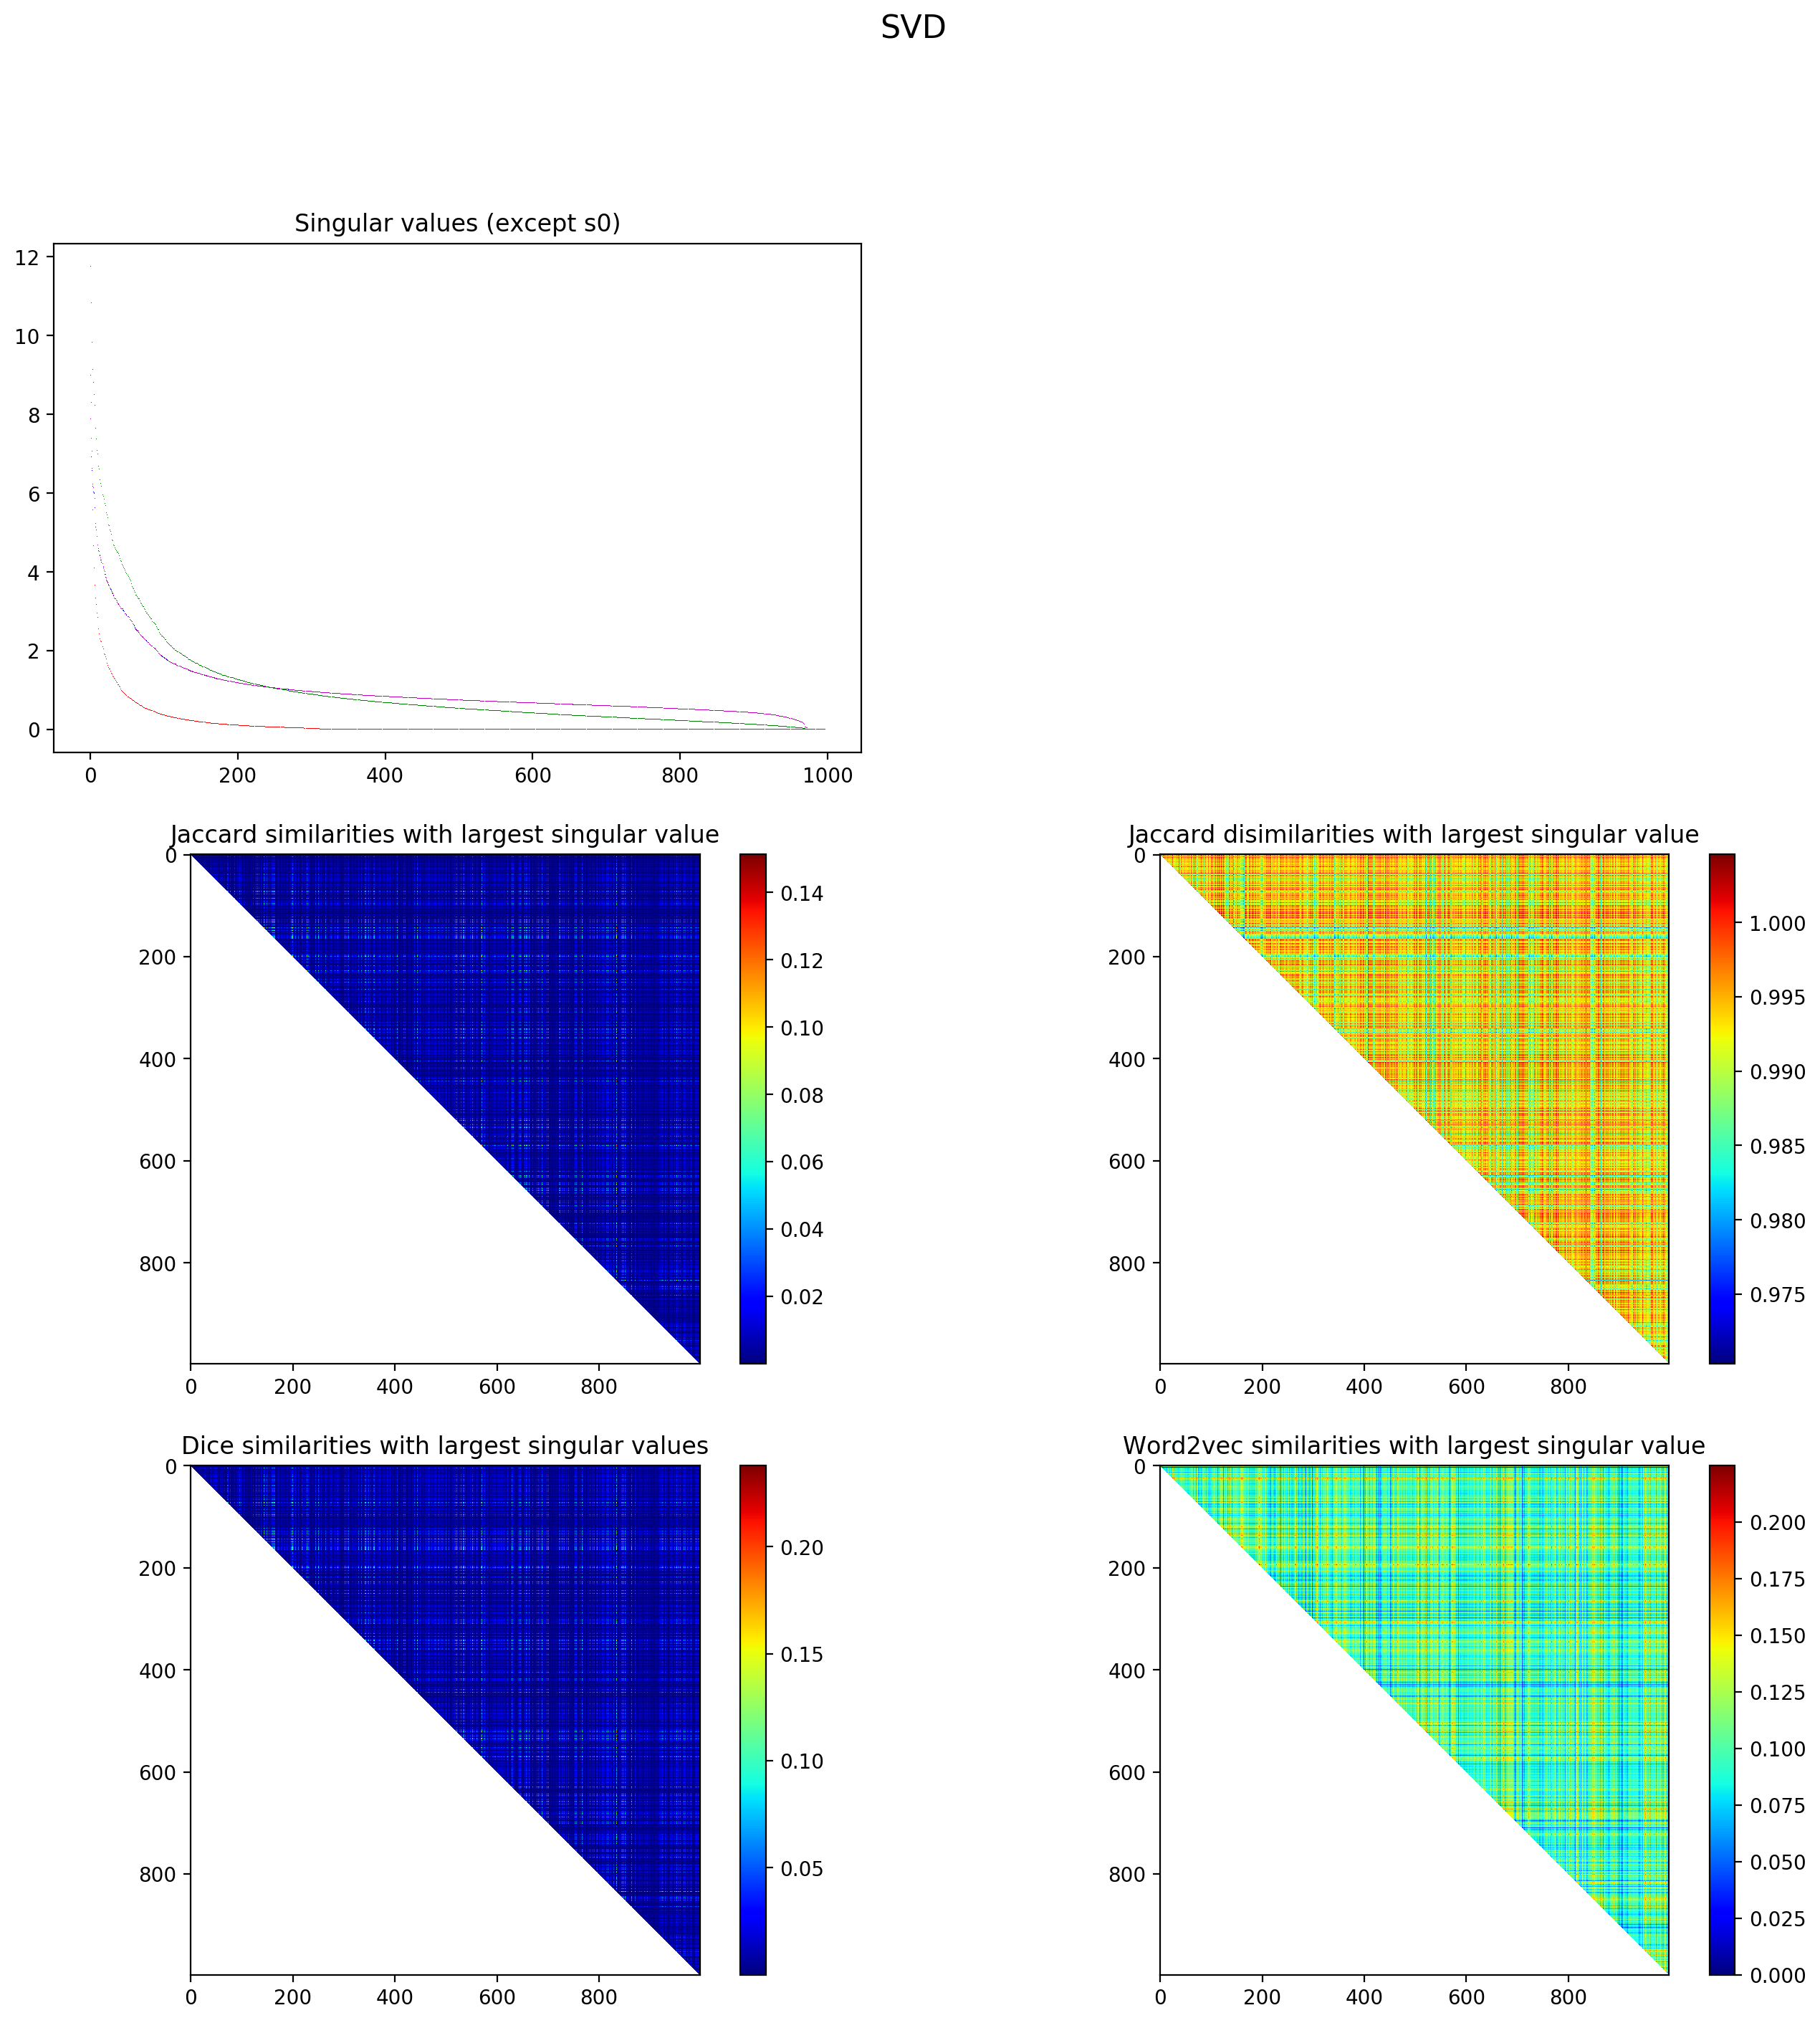

In [6]:
fig = plt.figure()
fig.suptitle("SVD", fontsize=16)

# Plotting singular values. s0 is too large for word2vec
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("Singular values (except s0)")
ax1.plot(jaccard_singular_values[1:], 'b,', mew=3.0)
ax1.plot(jaccarddis_singular_values[1:], 'm,', mew=1.0)
ax1.plot(dice_singular_values[1:], 'g,', mew=1.0)
ax1.plot(word2vec_singular_values[1:], 'r,', mew=1.0)

# Reconstructed matrix using the largest singular value.
ax_jaccard = plt.subplot(3, 2, 3)
ax_jaccard.set_title("Jaccard similarities with largest singular value")
im_jaccard = ax_jaccard.imshow(np.ma.array(jaccard_approximation, mask=mask))
plt.colorbar(im_jaccard)

# Reconstructed matrix using the largest singular value.
ax_jaccard_dis = plt.subplot(3, 2, 4)
ax_jaccard_dis.set_title("Jaccard disimilarities with largest singular value")
im_jaccarddis = ax_jaccard_dis.imshow(np.ma.array(jaccarddis_approximation, mask=mask))
plt.colorbar(im_jaccarddis)

# Reconstructed matrix using the largest singular value.
ax_dice = plt.subplot(3, 2, 5)
ax_dice.set_title("Dice similarities with largest singular values")
im_dice = ax_dice.imshow(np.ma.array(dice_approximation, mask=mask))
plt.colorbar(im_dice)

# Reconstructed matrix using the largest singular value.
ax_word2vec = plt.subplot(3, 2, 6)
ax_word2vec.set_title("Word2vec similarities with largest singular value")
im_word2vec = ax_word2vec.imshow(np.ma.array(word2vec_approximation, mask=mask))
plt.colorbar(im_word2vec)

plt.show()

In [7]:
# Means of jaccard similarities using the reconstructed matrix 
jaccard_similarity_mean = tf.reduce_mean(jaccard_approximation, 1)
# Ordered indices by mean of similarities in the approximation
jaccard_indices = sess.run(jaccard_similarity_mean).argsort()[::-1]

# Means of word2vec similarities using the reconstructed matrix 
word2vec_similarity_mean = tf.reduce_mean(word2vec_approximation, 1)
# Ordered indices by mean of similarities in the approximation
word2vec_indices = sess.run(word2vec_similarity_mean).argsort()[::-1]

# This Mask is a matrix with the same shape.
# Given the mask M, if m_{ij} is equal to zero it is marked as 1.0, otherwise as 0.0
jaccard_mask = sess.run(tf.where( tf.equal(matrix_jaccard, 0.0), 
                                 tf.ones(matrix_jaccard.get_shape()), tf.zeros(matrix_jaccard.get_shape())))

with sess.as_default():
    print("Jaccard matrix\n", matrix_jaccard[:3,:3].eval())
    print("\nJaccard mask\n", jaccard_mask[:3,:3])

# Given the mask M, each m_{ij} is mulpliyed by each element a_{ij} in A, 
# In this case, A represents the reconstructed matrix of word2vec similarities
jaccardmask_word2vecapprox = sess.run(tf.convert_to_tensor(jaccard_mask)*word2vec_approximation)

with sess.as_default():
    # The resulting word2vec matrix keeps only values of similitaties 
    # where jaccard has a similarity of zero
    print("\nword2vec (approx.)\n", word2vec_approximation[:3,:3])
    print("\nMaskered word2vec\n", jaccardmask_word2vecapprox[:3,:3])

Jaccard matrix
 [[1.         0.14285715 0.        ]
 [0.14285715 1.         0.        ]
 [0.         0.         1.        ]]

Jaccard mask
 [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]]

word2vec (approx.)
 [[0.07846789 0.06433386 0.10137664]
 [0.06433419 0.05274599 0.0831166 ]
 [0.10137682 0.08311632 0.13097385]]

Maskered word2vec
 [[0.         0.         0.10137664]
 [0.         0.         0.0831166 ]
 [0.10137682 0.08311632 0.        ]]


## There is semantic similarity (wor2vec) between documents even when they don't share common words (jaccard similarity equal to zero) 

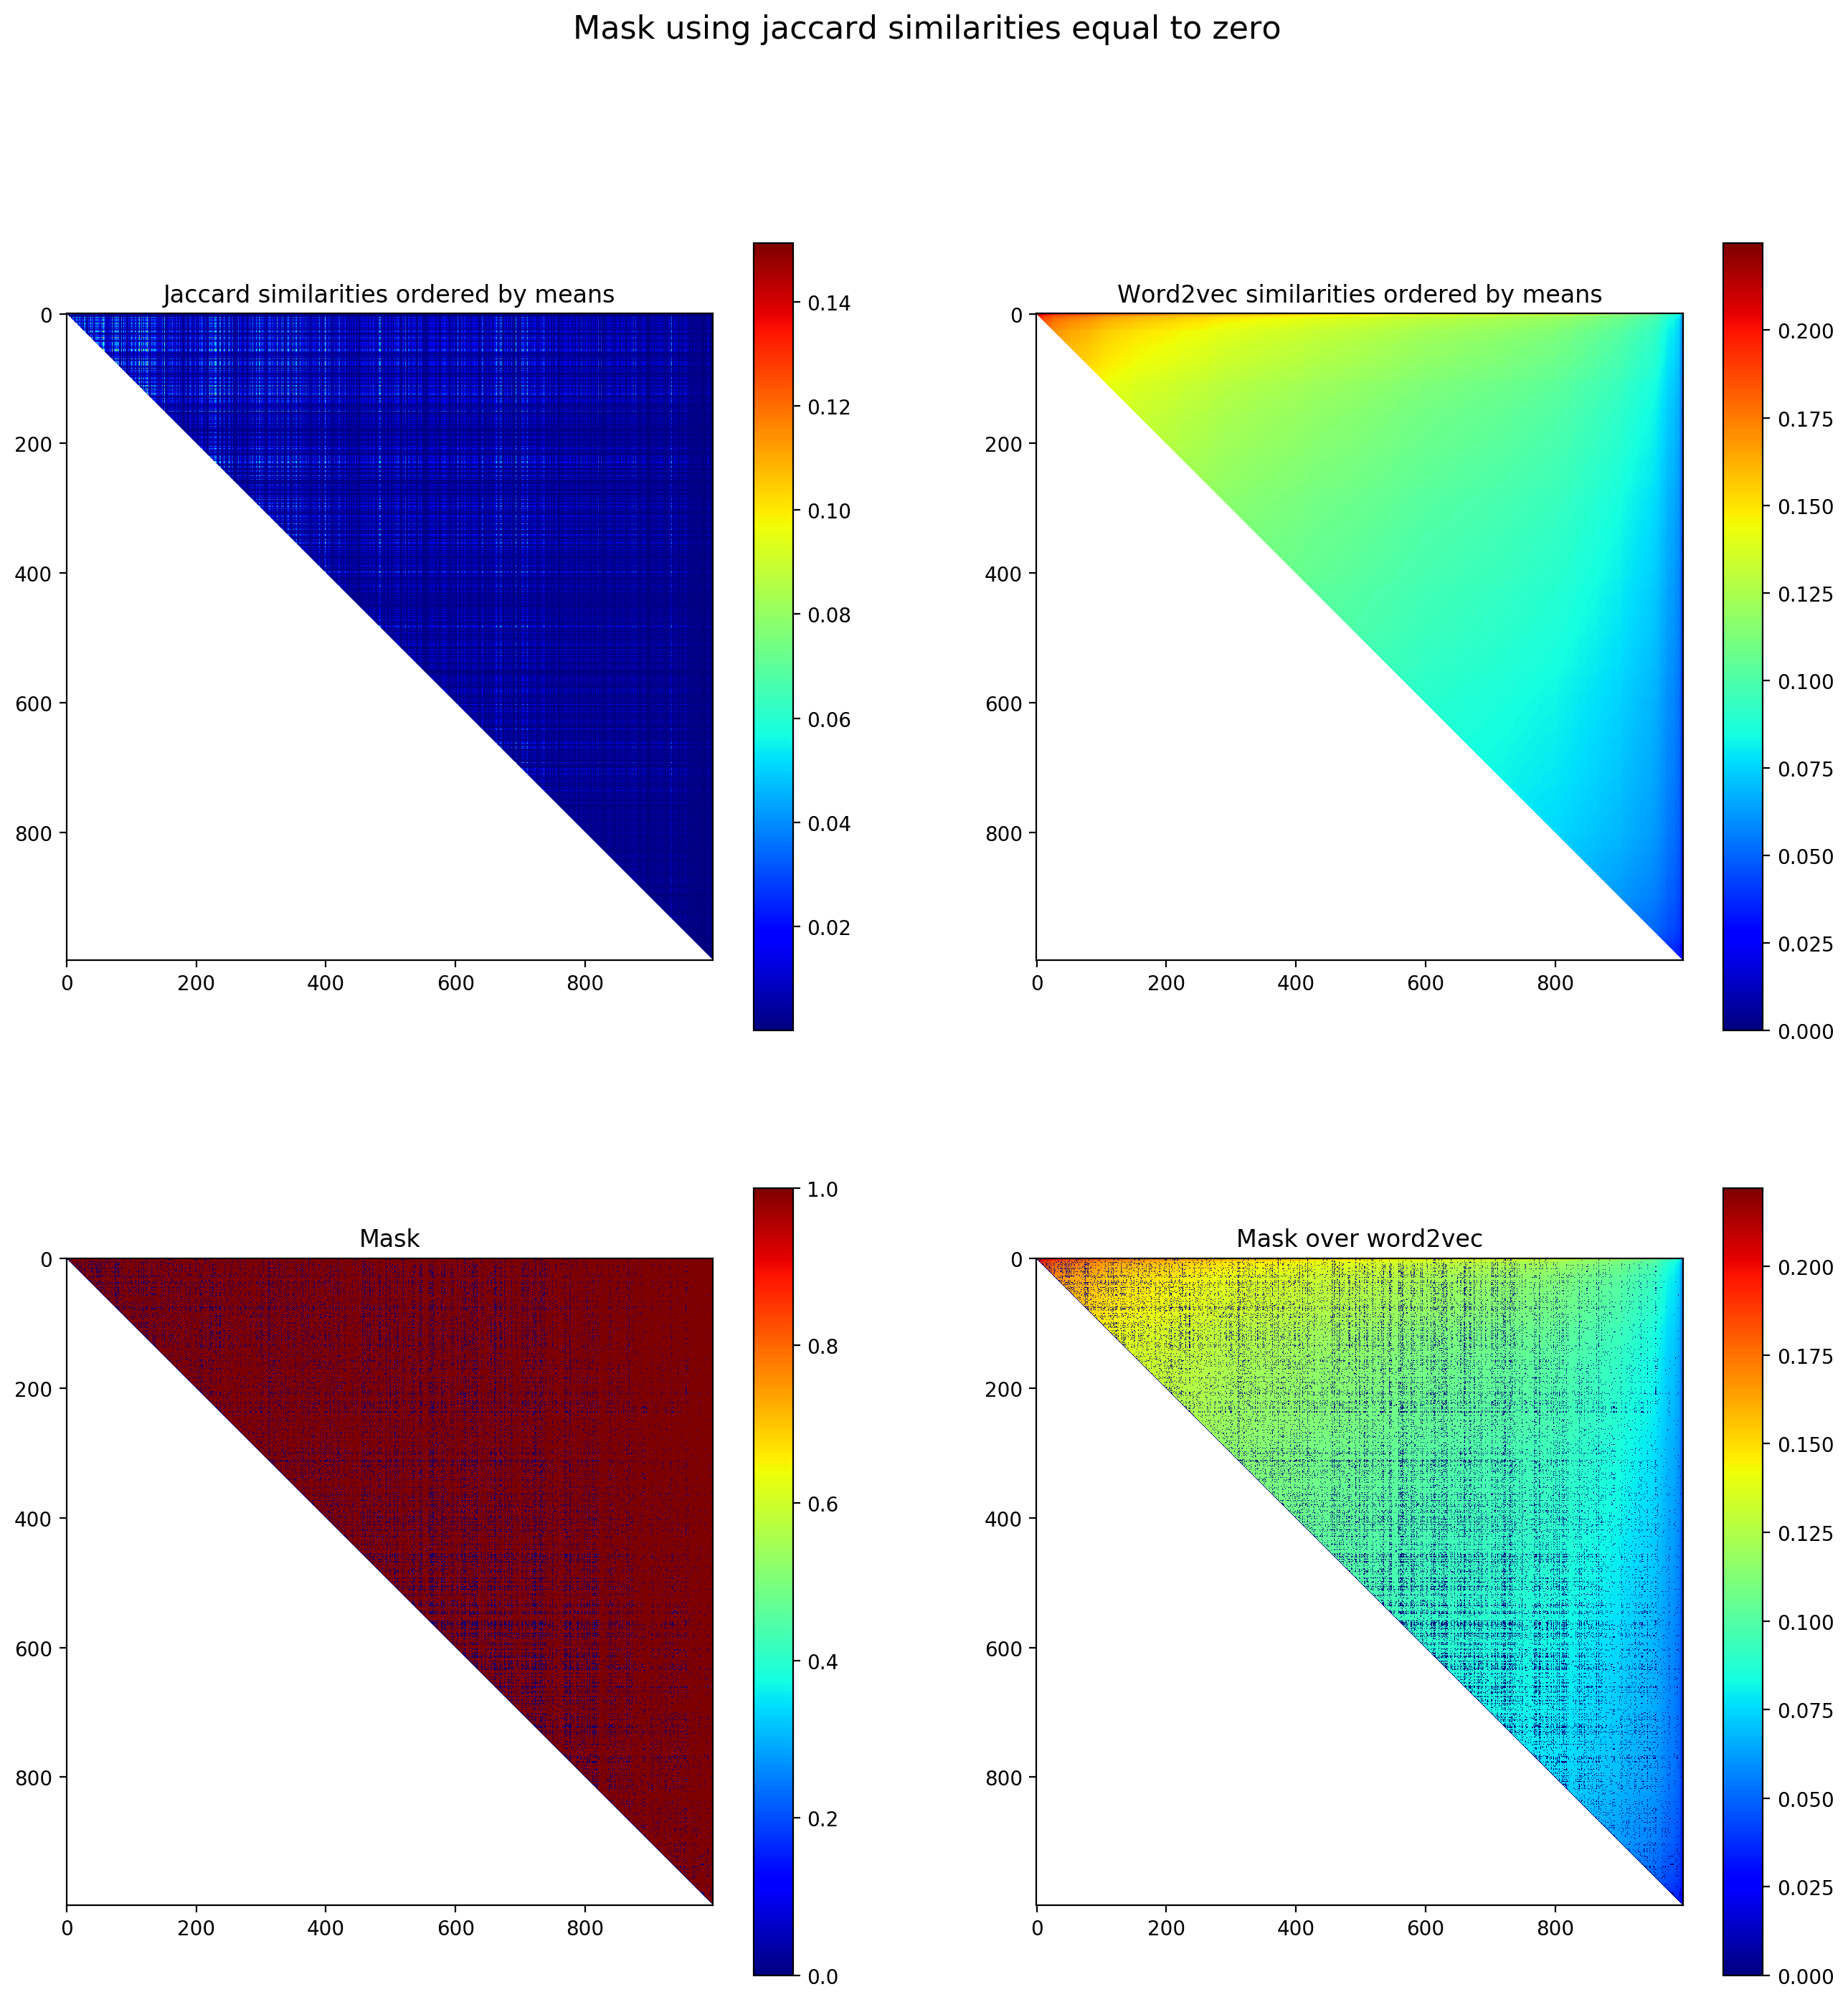

In [8]:
fig = plt.figure()
fig.suptitle("Mask using jaccard similarities equal to zero", fontsize=16)

ax_jaccard = plt.subplot(2, 2, 1)
ax_jaccard.set_title("Jaccard similarities ordered by means")
im_jaccard_arranged = ax_jaccard.imshow(np.ma.array(
    jaccard_approximation[:,word2vec_indices][word2vec_indices,:], mask=mask))
plt.colorbar(im_jaccard_arranged)

ax_word2vec = plt.subplot(2, 2, 2)
ax_word2vec.set_title("Word2vec similarities ordered by means")
im_word2vec_arranged = ax_word2vec.imshow(np.ma.array(
    word2vec_approximation[:,word2vec_indices][word2vec_indices,:], mask=mask))
plt.colorbar(im_word2vec_arranged)

ax_mask = plt.subplot(2, 2, 3)
ax_mask.set_title("Mask")
im_mask = ax_mask.imshow(np.ma.array(
    jaccard_mask[:,word2vec_indices][word2vec_indices,:], mask=mask))
plt.colorbar(im_mask)


ax_jm_wa = plt.subplot(2, 2, 4)
ax_jm_wa.set_title("Mask over word2vec")
im_jm_wa = ax_jm_wa.imshow(np.ma.array(
    jaccardmask_word2vecapprox[:,word2vec_indices][word2vec_indices,:], mask=mask))
plt.colorbar(im_jm_wa)

plt.show()